🔎 Querying NASA Exoplanet Archive (TOI table) for planets with unknown eccentricity...
Found 7714 TOIs. Processing first 1...

⭐ Processing TOI 1064.01 (TIC 79748331) — catalog period 6.4438657 d
✅ Light curve downloaded:        time             flux         flux_err       timecorr    ... mom_centr2_err   pos_corr1      pos_corr2   
                    electron / s   electron / s        d        ...      pix            pix            pix      
------------------ -------------- -------------- -------------- ... -------------- -------------- --------------
 1653.942120441185            ———            ———  4.8722392e-03 ...  1.6595848e-03 -2.3601992e-02 -1.0062421e-01
 1653.943509370926            ———            ———  4.8722806e-03 ...  1.6565415e-03 -2.4348523e-02 -1.0801895e-01
1653.9448983011323            ———            ———  4.8723225e-03 ...  1.6435697e-03 -2.3916455e-02 -1.0050855e-01
1653.9546208107138            ———            ———  4.8726141e-03 ...  1.6311986e-03 -2.3435032e-02 -1

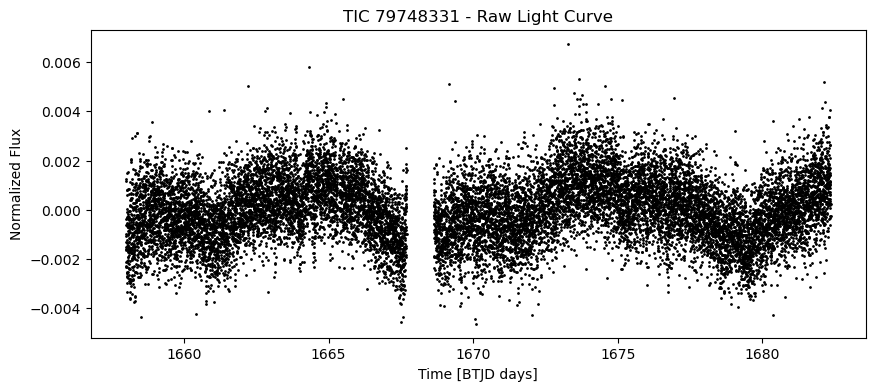

In [9]:
from astroquery.ipac.nexsci.nasa_exoplanet_archive import NasaExoplanetArchive
from lightkurve import search_lightcurve
from transitleastsquares import transitleastsquares
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")  # suppress minor warnings for clarity

def tls_candidates_unknown_ecc(max_targets=5):
    print("🔎 Querying NASA Exoplanet Archive (TOI table) for planets with unknown eccentricity...")

    # Query TOI table
    try:
        toi_table = NasaExoplanetArchive.query_criteria(
            table="toi",
            select="toi, tid, pl_orbper"
        ).to_pandas()
    except Exception as e:
        print("❌ Error querying NASA Exoplanet Archive:", e)
        return

    # Keep only targets with TIC ID and known orbital period
    toi_table = toi_table.dropna(subset=["tid", "pl_orbper"])
    print(f"Found {len(toi_table)} TOIs. Processing first {max_targets}...")

    for idx, row in toi_table.head(max_targets).iterrows():
        tic = str(row["tid"])
        catalog_period = row["pl_orbper"]
        print(f"\n⭐ Processing TOI {row['toi']} (TIC {tic}) — catalog period {catalog_period} d")

        # Download first available TESS light curve
        try:
            lc_search = search_lightcurve(f"TIC {tic}", mission="TESS")
            lc = lc_search.download()  # only first sector for speed
            if lc is None:
                print(f"❌ No TESS data found for TIC {tic}")
                continue
            print(f"✅ Light curve downloaded: {lc}")
        except Exception as e:
            print(f"❌ Error downloading LC for TIC {tic}: {e}")
            continue

        # Remove NaNs and normalize flux
        lc = lc.remove_nans()
        lc = lc.normalize()

        time = lc.time.value
        flux = lc.flux.value / np.nanmedian(lc.flux.value) - 1

        # Plot raw light curve
        plt.figure(figsize=(10, 4))
        plt.plot(time, flux, 'k.', markersize=2)
        plt.title(f"TIC {tic} - Raw Light Curve")
        plt.xlabel("Time [BTJD days]")
        plt.ylabel("Normalized Flux")
        plt.show()

       

# Example usage:
tls_candidates_unknown_ecc(max_targets=1)
